### New Data Analysis

In [1]:
import pandas as pd
import h5py as h5
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
import scipy.io as sio
import itertools
import pickle as pkl
import matplotlib.ticker as ticker


In [2]:
def get_joint_prob_distr(target, source_var1, source_var2, source_var3):
    
    count = len(source_var1)

    # compute probabilities from (multi-dim) histogram frequencies
    result, _ = np.histogramdd(
        np.vstack([source_var1, source_var2, source_var3, target]).T, 
        bins=[np.max(source_var1), np.max(source_var2), np.max(source_var3), np.max(target)]
    )
    
    return result / count

In [3]:
def get_SUI(joint_prob_distr):

    # get dimensions
    dim_x_past = joint_prob_distr.shape[0]
    dim_y_pres = joint_prob_distr.shape[1]
    dim_y_past = joint_prob_distr.shape[2]
    dim_s = joint_prob_distr.shape[3]

    # initialize arrays
    spec_surprise_x = np.zeros(dim_s)
    spec_surprise_y = np.zeros(dim_s)
    spec_surprise_y_past = np.zeros(dim_s)

    # compute specific information provided by each source variable about s (target)
    for s in range(dim_s):

        # p(s)
        ps = np.sum(joint_prob_distr[:, :, :, s]) 

        # info provided by x past
        for x in range(dim_x_past):
            psx = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[x, :, :, :]) + np.finfo(float).eps)
            pxs = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)

            spec_surprise_x[s] += pxs * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psx + np.finfo(float).eps)))

        # info provided by y
        for y in range(dim_y_pres):
            psy = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, y, :, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

        # info provided by y past
        for y in range(dim_y_past):
            psy = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, y, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y_past[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

    # compute IMin

    IMin_x_y_ypast = 0
    IMin_x_y = 0

    for s in range(dim_s):
        IMin_x_y_ypast += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s], spec_surprise_y_past[s])
        IMin_x_y += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s])

    return IMin_x_y - IMin_x_y_ypast

In [4]:
def compute_TE(joint_prob_distr):

    p_ypast = np.sum(joint_prob_distr, axis=(0, 1, 3))
    p_x_ypast = np.sum(joint_prob_distr, axis=(1, 3))
    p_y_ypast = np.sum(joint_prob_distr, axis=(0, 3))
    p_x_y_ypast = np.sum(joint_prob_distr, axis=3)
    
    def entropy(p):
        p_nonzero = p[p > 0]  # Avoid log of zero
        return - np.sum(p_nonzero * np.log2(p_nonzero))
    
    h_ypast = entropy(p_ypast)
    h_x_ypast = entropy(p_x_ypast)
    h_y_ypast = entropy(p_y_ypast)
    h_x_y_ypast = entropy(p_x_y_ypast)
    
    return h_y_ypast - h_ypast - h_x_y_ypast + h_x_ypast

In [5]:
def compute_DFI(joint_prob_distr):
    
    # marginal distributions
    prob_ypast = np.sum(joint_prob_distr, axis=(0, 1, 3))
    prob_x_ypast = np.sum(joint_prob_distr, axis=(1, 3))
    prob_y_ypast = np.sum(joint_prob_distr, axis=(0, 3))
    prob_ypast_s = np.sum(joint_prob_distr, axis=(0, 1))
    prob_x_y_ypast = np.sum(joint_prob_distr, axis=3)
    prob_y_ypast_s = np.sum(joint_prob_distr, axis=0)
    prob_x_ypast_s = np.sum(joint_prob_distr, axis=1)
    
    def get_entropy(prob_dist):
        prob_nonzero = prob_dist[prob_dist > 0]  # Filter out zero values
        return -np.sum(prob_nonzero * np.log2(prob_nonzero))
    
    # entropies
    h_ypast = get_entropy(prob_ypast)
    h_x_ypast = get_entropy(prob_x_ypast)
    h_y_ypast = get_entropy(prob_y_ypast)
    h_ypast_s = get_entropy(prob_ypast_s)
    h_x_y_ypast = get_entropy(prob_x_y_ypast)
    h_y_ypast_s = get_entropy(prob_y_ypast_s)
    h_x_ypast_s = get_entropy(prob_x_ypast_s)
    h_x_y_ypast_s = get_entropy(joint_prob_distr)
    
    # compute DFI
    dfi = h_y_ypast - h_ypast - h_x_y_ypast + h_x_ypast - h_y_ypast_s + h_ypast_s + h_x_y_ypast_s - h_x_ypast_s
    
    return dfi

In [32]:
def compute_FIT_TE_DFI(feature, X, Y, hY, xtrap=20):
    # Build the two four-variables probability distributions needed to compute FIT
    pXYhYS = get_joint_prob_distr(feature, X, Y, hY)    # probability distribution for the PID with (Xp, Yp, Yt) as sources and S as target
    pXShYY = get_joint_prob_distr(Y, X, feature, hY)    # probability distribution for the PID with (Xp, Yp, S) as sources and Yt as target

    # Compute the two FIT atoms and FIT
    sui_S = get_SUI(pXYhYS)
    sui_Y = get_SUI(pXShYY)

    fit = np.min([sui_S, sui_Y])

    # Compute TE
    te = compute_TE(pXYhYS)

    # Compute DFI
    dfi = compute_DFI(pXYhYS)

    # Compute quadratic extrapolation bias correction for FIT and TE
    fit_all = fit
    te_all = te

    FIT2 = np.zeros(xtrap)
    FIT4 = np.zeros(xtrap)
    TE2 = np.zeros(xtrap)
    TE4 = np.zeros(xtrap)

    for xIdx in range(xtrap):

        numberOfTrials = len(X)

        # Shuffled indexes in 0,ntrials range
        rIdx = npr.choice(numberOfTrials, numberOfTrials, replace=False)
        # Divide the indexes in 2 and 4 parts
        idx2 = np.array_split(rIdx, 2) 
        idx4 = np.array_split(rIdx, 4)
        
        # Stack all the sources in data, separate into 2 and 4 parts, and distinguish between s and y targets
        data = np.stack(np.array([feature, X, Y, hY]),axis=1)
        data2_s = np.stack(np.array([data[idx2[i]] for i in range(2)]), axis = 0)
        

        data2_y = data2_s[:, :, [2, 1, 0, 3]]
        data2_tot = np.stack(np.array([data2_s,data2_y]), axis=0)
        
        data4_s = np.stack(np.array([data[idx4[i]] for i in range(4)]), axis = 0)
        data4_y = data4_s[:, :, [2, 1, 0, 3]]
        data4_tot = np.stack(np.array([data4_s,data4_y]), axis=0)
        
        # Compute Joint, SUI, FIT and TE for the 2 divided version
        joint2 = [[
            get_joint_prob_distr(*[data2_tot[ch,row, :, i] for i in range(4)])
            for row in range(data2_tot.shape[1])]
            for ch in range(data2_tot.shape[0])
        ]
        
        SUI_2 = [[get_SUI(joint2[ch][i]) for i in range(2)] for ch in range(len(joint2))]
        FIT2[xIdx] = np.mean(np.min(SUI_2,axis=0))
        TE2[xIdx] = np.mean([compute_TE(joint2[0][i]) for i in range(2)])
        
        # Compute Joint, SUI, FIT and TE for the 4 divided version
        joint4 = [[
            get_joint_prob_distr(*[data4_tot[ch,row, :, i] for i in range(4)])
            for row in range(data4_tot.shape[1])]
            for ch in range(data4_tot.shape[0])
        ]

        
        SUI_4 = [[get_SUI(joint4[ch][i]) for i in range(4)] for ch in range(len(joint4))]
        FIT4[xIdx] = np.mean(np.min(SUI_4,axis=0))
        TE4[xIdx] = np.mean([compute_TE(joint4[0][i]) for i in range(4)])


    # Compute the linear and quadratic interpolations for FIT and TE

    x = [1/len(idx2[0]), 1/len(idx4[0]), 1/len(rIdx)]
    y = [np.mean(FIT4), np.mean(FIT2), fit_all]

    p2 = np.polyfit(x, y, 2)
    p1 = np.polyfit(x, y, 1) 
    FITQe = p2[2]
    FITLe = p1[1]
         
    y = [np.mean(TE4), np.mean(TE2), te_all]
    
    p2 = np.polyfit(x, y, 2)
    p1 = np.polyfit(x, y, 1) 
    TEQe = p2[2]
    TELe = p1[1]

    return te, dfi, fit, TEQe, TELe, FITQe, FITLe

In [7]:
max_delay = 60
bins = 3

In [ ]:
pd.loadmat()

In [8]:
with open('data/new_data.pkl', 'rb') as f:
    data_raw = pkl.load(f) # deserialize using load()
    data = np.transpose(data_raw, (1,2,0))

In [8]:
with open('results_correct_800.pkl', 'rb') as f:
    data_raw = pkl.load(f) # deserialize using load()
    lr_di_vis = data_raw[0]
    lr_fit_vis = data_raw[1]
    rl_di_vis = data_raw[2] 
    rl_fit_vis = data_raw[3] 
    lr_di_mot = data_raw[4] 
    lr_fit_mot = data_raw[5] 
    rl_di_mot = data_raw[6] 
    rl_fit_mot = data_raw[7]

In [10]:
rl_di_mot[230,:]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [97]:
# Channels to consider
left_visual = 97 
right_visual = 149 
left_motor = 185  
right_motor = 52

timesteps = np.shape(data)[1]

In [288]:
file_path = 'data/data.mat'
data_set = sio.loadmat(file_path)
time = data_set['B'][0][0]['times'][0]
data = data_set['B'][0][0]['data']

ch_num = np.shape(data)[0]



In [14]:
df = pd.read_excel("data/P1.xlsx", sheet_name=0, header=None)
exc_f = df.to_numpy()
S_original = exc_f[:,2]
unique_words, S_raw = np.unique(S_original, return_inverse=True)
S = S_raw + 1

In [290]:
np.shape(data)

(256, 600, 80)

In [10]:
df = pd.read_excel("data/P1 (1).xlsx", sheet_name=0)
exc_f = df.to_numpy()
S_original = exc_f[:,2]
unique_words, S_raw = np.unique(S_original, return_inverse=True)
S = S_raw + 1

In [96]:
lr_fit_vis = np.full((timesteps-max_delay, max_delay), np.nan)
lrl_fit_vis = lr_fit_vis.copy()
lrq_fit_vis = lr_fit_vis.copy()
lr_di_vis = lr_fit_vis.copy()
lrl_di_vis = lr_fit_vis.copy()
lrq_di_vis = lr_fit_vis.copy()
rl_fit_vis = lr_fit_vis.copy()
rll_fit_vis = lr_fit_vis.copy()
rlq_fit_vis = lr_fit_vis.copy()
rl_di_vis = lr_fit_vis.copy()
rll_di_vis = lr_fit_vis.copy()
rlq_di_vis = lr_fit_vis.copy()
lr_fit_mot = lr_fit_vis.copy()
lrl_fit_mot = lr_fit_vis.copy()
lrq_fit_mot = lr_fit_vis.copy()
lr_di_mot = lr_fit_vis.copy()
lrl_di_mot = lr_fit_vis.copy()
lrq_di_mot = lr_fit_vis.copy()
rl_fit_mot = lr_fit_vis.copy()
rll_fit_mot = lr_fit_vis.copy()
rlq_fit_mot = lr_fit_vis.copy()
rl_di_mot = lr_fit_vis.copy()
rll_di_mot = lr_fit_vis.copy()
rlq_di_mot = lr_fit_vis.copy()

In [243]:
lr_fit_mot[429,:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.03946154e-06,
       2.70682764e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.55570506e-04, 1.48846568e-03, 5.43385113e-04, 0.00000000e+00,
       9.03946154e-06, 9.03946154e-06, 0.00000000e+00, 1.81813709e-03,
       0.00000000e+00, 0.00000000e+00, 9.03946154e-06, 1.50123608e-03,
       0.00000000e+00, 9.03946154e-06, 0.00000000e+00, 3.08749770e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.45554781e-04, 0.00000000e+00, 1.63393453e-03, 0.00000000e+00,
       0.00000000e+00, 9.03946154e-06, 3.46853077e-03, 0.00000000e+00,
       5.66691659e-04, 0.00000000e+00, 0.00000000e+00, 9.03946154e-06,
       0.00000000e+00, 9.03946154e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.03946154e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.29601097e-03, 0.00000000e+00, 9.03946154e-06,
      

In [98]:
data_vis_left = data[left_visual,:,:]
data_vis_right = data[right_visual,:,:]
data_mot_left = data[left_motor,:,:]
data_mot_right = data[right_motor,:,:]

In [102]:
def inner_cycle (temp2, d):

    temp = temp2 + 100
    t = temp + max_delay + 1

    # Discretize Neural Signals
    # Visual
    #_, bin_edges = pd.qcut(data_vis_left[t,:], bins, retbins=True)
    #L_sig_vis = np.digitize(data_vis_left[t,:], bins=bin_edges, right=False)
    L_sig_vis = pd.qcut(data_vis_left[t,:], bins, labels=range(1,bins+1)).astype(int)

    #_, bin_edges = pd.qcut(data_vis_left[t-d,:], bins, retbins=True)
    #L_sig_vis_p = np.digitize(data_vis_left[t-d,:], bins=bin_edges, right=False)
    L_sig_vis_p = pd.qcut(data_vis_left[t-d,:], bins, labels=range(1,bins+1)).astype(int)

    #_, bin_edges = pd.qcut(data_vis_right[t,:], bins, retbins=True)
    #R_sig_vis = np.digitize(data_vis_right[t,:], bins=bin_edges, right=False)
    R_sig_vis = pd.qcut(data_vis_right[t,:], bins, labels=range(1,bins+1)).astype(int)
    #_, bin_edges = pd.qcut(data_vis_right[t-d,:], bins, retbins=True)
    #R_sig_vis_p = np.digitize(data_vis_right[t-d,:], bins=bin_edges, right=False)
    R_sig_vis_p = pd.qcut(data_vis_right[t-d,:], bins, labels=range(1,bins+1)).astype(int)

    # Motor
    #_, bin_edges = pd.qcut(data_mot_left[t,:], bins, retbins=True)
    #L_sig_mot = np.digitize(data_mot_left[t,:], bins=bin_edges, right=False)
    L_sig_mot = pd.qcut(data_mot_left[t,:], bins, labels=range(1,bins+1)).astype(int)

    #_, bin_edges = pd.qcut(data_mot_left[t-d,:], bins, retbins=True)
    #L_sig_mot_p = np.digitize(data_mot_left[t-d,:], bins=bin_edges, right=False)
    L_sig_mot_p = pd.qcut(data_mot_left[t-d,:], bins, labels=range(1,bins+1)).astype(int)

    #_, bin_edges = pd.qcut(data_mot_right[t,:], bins, retbins=True)
    #R_sig_mot = np.digitize(data_mot_right[t,:], bins=bin_edges, right=False)
    R_sig_mot = pd.qcut(data_mot_right[t,:], bins, labels=range(1,bins+1)).astype(int)

    #_, bin_edges = pd.qcut(data_mot_right[t-d,:], bins, retbins=True)
    #R_sig_mot_p = np.digitize(data_mot_right[t-d,:], bins=bin_edges, right=False)
    R_sig_mot_p = pd.qcut(data_mot_right[t-d,:], bins, labels=range(1,bins+1)).astype(int)

    # Left to right Visual

    lr_di_vis, _ , lr_fit_vis, lrq_di_vis, lrl_di_vis, lrq_fit_vis, lrl_fit_vis = compute_FIT_TE_DFI(S, L_sig_vis_p, R_sig_vis, R_sig_vis_p)    

    # Right to left Visual

    rl_di_vis, _ , rl_fit_vis, rlq_di_vis, rll_di_vis, rlq_fit_vis, rll_fit_vis = compute_FIT_TE_DFI(S, R_sig_vis_p, L_sig_vis, L_sig_vis_p)    

    # Left visual to right motor

    lr_di_mot, _ , lr_fit_mot, lrq_di_mot, lrl_di_mot, lrq_fit_mot, lrl_fit_mot = compute_FIT_TE_DFI(S, L_sig_vis_p, R_sig_mot, R_sig_mot_p) 

    # Right visual to left motor

    rl_di_mot, _ , rl_fit_mot, rlq_di_mot, rll_di_mot, rlq_fit_mot, rll_fit_mot = compute_FIT_TE_DFI(S, R_sig_vis_p, L_sig_mot, L_sig_mot_p)    
    
    return temp, d, lr_di_vis, lr_fit_vis, lrq_di_vis, lrl_di_vis, lrq_fit_vis, lrl_fit_vis, rl_di_vis, rl_fit_vis, rlq_di_vis, rll_di_vis, rlq_fit_vis, rll_fit_vis, lr_di_mot, lr_fit_mot, lrq_di_mot, lrl_di_mot, lrq_fit_mot, lrl_fit_mot, rl_di_mot, rl_fit_mot, rlq_di_mot, rll_di_mot, rlq_fit_mot, rll_fit_mot
                
    

In [34]:
lr_di_mot[479,:]

array([0.        , 0.02370097, 0.03385238, 0.03161662, 0.02578348,
       0.02218215, 0.02662693, 0.02215679, 0.03454747, 0.02841638,
       0.02718644, 0.04866382, 0.0480609 , 0.03913185, 0.05730773,
       0.04684701, 0.04699485, 0.03630683, 0.03614018, 0.04821832,
       0.04382644, 0.04842976, 0.03517948, 0.03826933, 0.04777347,
       0.05663853, 0.04268783, 0.03251152, 0.03201181, 0.03098038,
       0.04114078, 0.0262307 , 0.02164638, 0.03101965, 0.04247931,
       0.032725  , 0.02971727, 0.02155085, 0.02969788, 0.02988508,
       0.04150622, 0.04019799, 0.04638758, 0.04197451, 0.03804844,
       0.03856924, 0.03982923, 0.04189457, 0.02601586, 0.03118055,
       0.02725693, 0.02611744, 0.03240711, 0.03408613, 0.0375395 ,
       0.03933184, 0.03705431, 0.04261899, 0.0465539 , 0.04437656])

In [217]:
for res in results:
    t, d, lrdivis, lrfitvis, rldivis, rlfitvis, lrdimot, lrfitmot, rldimot, rlfitmot = res
    lr_di_vis[t, d] = lrdivis
    lr_fit_vis[t, d] = lrfitvis
    rl_di_vis[t, d] = rldivis
    rl_fit_vis[t, d] = rlfitvis
    lr_di_mot[t, d] = lrdimot
    lr_fit_mot[t, d] = lrfitmot
    rl_di_mot[t, d] = rldimot
    rl_fit_mot[t, d] = rlfitmot

In [75]:
lr_di_vis[349,0]

np.float64(0.0)

In [103]:
index_iter = product(range(100), range(max_delay))
results = Parallel(n_jobs=-1,verbose=10)(
delayed(inner_cycle)(*pair) for pair in index_iter
)
    

for res in results:
    t, d, lrdivis, lrfitvis, lrqdivis, lrldivis, lrqfitvis, lrlfitvis, rldivis, rlfitvis, rlqdivis, rlldivis, rlqfitvis, rllfitvis, lrdimot, lrfitmot, lrqdimot, lrldimot, lrqfitmot, lrlfitmot, rldimot, rlfitmot, rlqdimot, rlldimot, rlqfitmot, rllfitmot = res
    lr_di_vis[t, d] = lrdivis
    lr_fit_vis[t, d] = lrfitvis
    lrq_di_vis[t, d] = lrqdivis
    lrl_di_vis[t, d] = lrldivis
    lrq_fit_vis[t, d] = lrqfitvis
    lrl_fit_vis[t, d] = lrlfitvis
    rl_di_vis[t, d] = rldivis
    rl_fit_vis[t, d] = rlfitvis
    rlq_di_vis[t, d] = rlqdivis
    rll_di_vis[t, d] = rlldivis
    rlq_fit_vis[t, d] = rlqfitvis
    rll_fit_vis[t, d] = rllfitvis
    lr_di_mot[t, d] = lrdimot
    lr_fit_mot[t, d] = lrfitmot
    lrq_di_mot[t, d] = lrqdimot
    lrl_di_mot[t, d] = lrldimot
    lrq_fit_mot[t, d] = lrqfitmot
    lrl_fit_mot[t, d] = lrlfitmot
    rl_di_mot[t, d] = rldimot
    rl_fit_mot[t, d] = rlfitmot
    rlq_di_mot[t, d] = rlqdimot
    rll_di_mot[t, d] = rlldimot
    rlq_fit_mot[t, d] = rlqfitmot
    rll_fit_mot[t, d] = rllfitmot

         


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

In [65]:
for temp2 in range(1):

    temp = temp2
    t = temp + max_delay + 1
    print('Time: ',t)

    for d in range(max_delay):
                    
        print('Delay: ',d)

        # Discretize Neural Signals
        # Visual
        _, bin_edges = pd.qcut(data_vis_left[t,:], bins, retbins=True)
        L_sig_vis = np.digitize(data_vis_left[t,:], bins=bin_edges, right=False)

        L_sig_vis_alt = pd.qcut(data_vis_left[t,:], bins, labels=range(1,bins+1)).astype(int)
        
        _, bin_edges = pd.qcut(data_vis_left[t-d,:], bins, retbins=True)
        L_sig_vis_p = np.digitize(data_vis_left[t-d,:], bins=bin_edges, right=False)
        _, bin_edges = pd.qcut(data_vis_right[t,:], bins, retbins=True)
        R_sig_vis = np.digitize(data_vis_right[t,:], bins=bin_edges, right=False)
        _, bin_edges = pd.qcut(data_vis_right[t-d,:], bins, retbins=True)
        R_sig_vis_p = np.digitize(data_vis_right[t-d,:], bins=bin_edges, right=False)

        # Motor
        _, bin_edges = pd.qcut(data_mot_left[t,:], bins, retbins=True)
        L_sig_mot = np.digitize(data_mot_left[t,:], bins=bin_edges, right=False)
        _, bin_edges = pd.qcut(data_mot_left[t-d,:], bins, retbins=True)
        L_sig_mot_p = np.digitize(data_mot_left[t-d,:], bins=bin_edges, right=False)
        _, bin_edges = pd.qcut(data_mot_right[t,:], bins, retbins=True)
        R_sig_mot = np.digitize(data_mot_right[t,:], bins=bin_edges, right=False)
        _, bin_edges = pd.qcut(data_mot_right[t-d,:], bins, retbins=True)
        R_sig_mot_p = np.digitize(data_mot_right[t-d,:], bins=bin_edges, right=False)

        # Left to right Visual

        lr_di_vis[temp, d], _ , lr_fit_vis[temp, d] = compute_FIT_TE_DFI(S, L_sig_vis_p, R_sig_vis, R_sig_vis_p)    

        # Right to left Visual

        rl_di_vis[temp, d], _ , rl_fit_vis[temp, d] = compute_FIT_TE_DFI(S, R_sig_vis_p, L_sig_vis, L_sig_vis_p)    

        # Left visual to right motor

        lr_di_mot[temp, d], _ , lr_fit_mot[temp, d] = compute_FIT_TE_DFI(S, L_sig_vis_p, R_sig_mot, R_sig_mot_p) 

        # Right visual to left motor

        rl_di_mot[temp, d], _ , rl_fit_mot[temp, d] = compute_FIT_TE_DFI(S, R_sig_vis_p, L_sig_mot, L_sig_mot_p)    
                

Time:  61
Delay:  0
Delay:  1
Delay:  2
Delay:  3


KeyboardInterrupt: 

In [105]:
with open('results_wrong_800_all.pkl', 'wb') as f:  # open a text file
    pkl.dump([lr_di_vis, lr_fit_vis, lrq_di_vis, lrl_di_vis, lrq_fit_vis, lrl_fit_vis, rl_di_vis, rl_fit_vis, rlq_di_vis, rll_di_vis, rlq_fit_vis, rll_fit_vis, lr_di_mot, lr_fit_mot, lrq_di_mot, lrl_di_mot, lrq_fit_mot, lrl_fit_mot, rl_di_mot, rl_fit_mot, rlq_di_mot, rll_di_mot, rlq_fit_mot, rll_fit_mot], f) # serialize the list

In [93]:
def plot_map4(l_array, r_array, title):
    fig, ax = plt.subplots(nrows = 2, ncols =2, figsize=(16,10))

    l = ax[0][0].imshow(l_array, origin='lower', cmap='plasma')
    r = ax[0][1].imshow(r_array, origin='lower', cmap='cividis')

    l_m = np.mean(l_array, axis = 0)
    r_m = np.mean(r_array, axis = 0)
    
    l_s = np.std(l_array, axis=0)/np.sqrt(15+120)
    r_s = np.std(r_array, axis=0)/np.sqrt(15+120)

    tmax = l_m.shape[0]

    t = np.arange(tmax)

    ax[1][0].grid(alpha=0.3)
    ax[1][0].plot(l_m, label='mean', color='C1')
    ax[1][0].set_title('Left to Right ' + title + ' averaged over delays')
    ax[1][0].fill_between(t, l_m-l_s, l_m+l_s, alpha=0.4, label = 'mean error', color='C1')
    ax[1][0].legend()
    ax[1][0].set_xlabel('peri-stimulus time (ms)')
    ax[1][0].set_ylabel('bits')

    ax[1][1].grid(alpha=0.3)
    ax[1][1].plot(r_m, label='mean')
    ax[1][1].set_title('Right to Left ' + title + ' averaged over delays')
    ax[1][1].fill_between(t, r_m-r_s, r_m+r_s, alpha=0.4, label = 'mean error', color='C0')
    ax[1][1].legend()
    ax[1][1].set_xlabel('peri-stimulus time (ms)')
    ax[1][1].set_ylabel('bits')

    l_cbar = ax[0][0].figure.colorbar(l, label='bits', location = 'bottom', pad = 0.15)
    r_cbar = ax[0][1].figure.colorbar(r, label='bits', location = 'bottom', pad = 0.15)

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))  

    l_cbar.ax.xaxis.set_major_formatter(formatter)
    r_cbar.ax.xaxis.set_major_formatter(formatter)   

    ax[1][0].yaxis.set_major_formatter(formatter)
    ax[1][1].yaxis.set_major_formatter(formatter)

    ax[0][0].set_xlim(0,539)
    ax[0][1].set_xlim(0,539)

    ax[0][0].set_xlabel('peri-stimulus time (ms)')
    ax[0][1].set_xlabel('peri-stimulus time (ms)')

    ax[0][0].set_ylabel('delay (ms)')
    ax[0][1].set_ylabel('delay (ms)')

    ax[0][0].set_title('Left to Right ' + title)
    ax[0][1].set_title('Right to Left ' + title)

    plt.show()

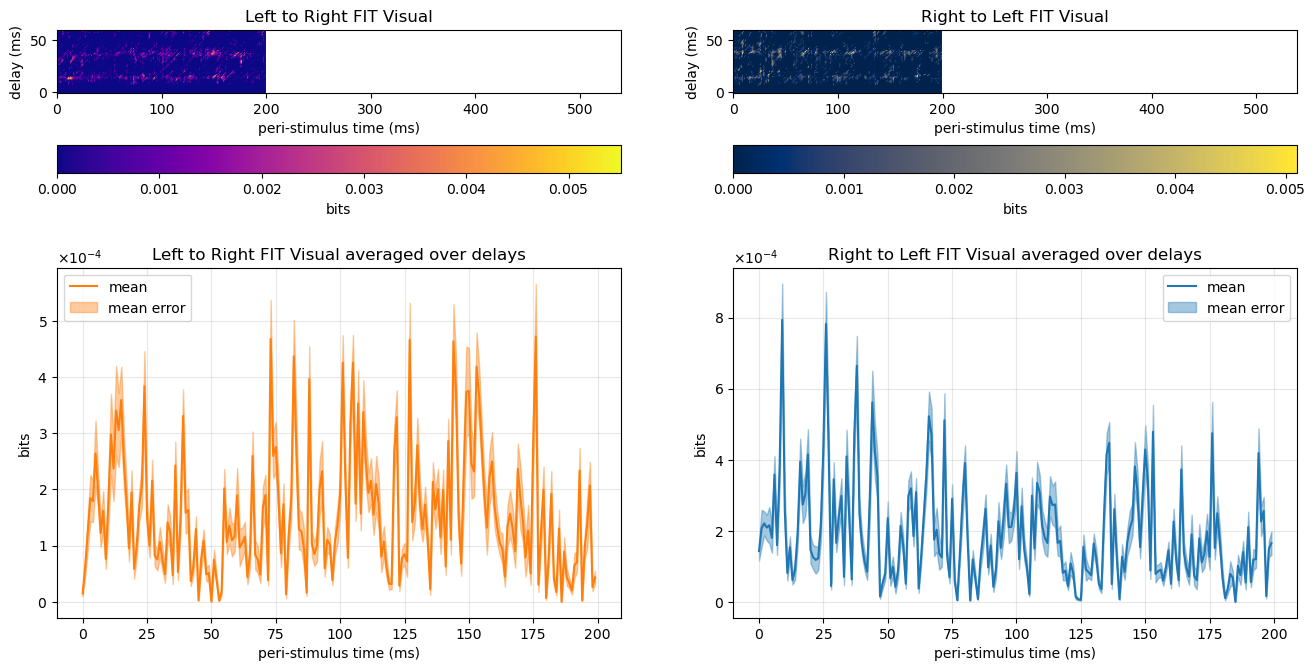

In [104]:
plot_map4(lr_fit_vis.T[:,0:539], rl_fit_vis.T[:,0:539], 'FIT Visual')

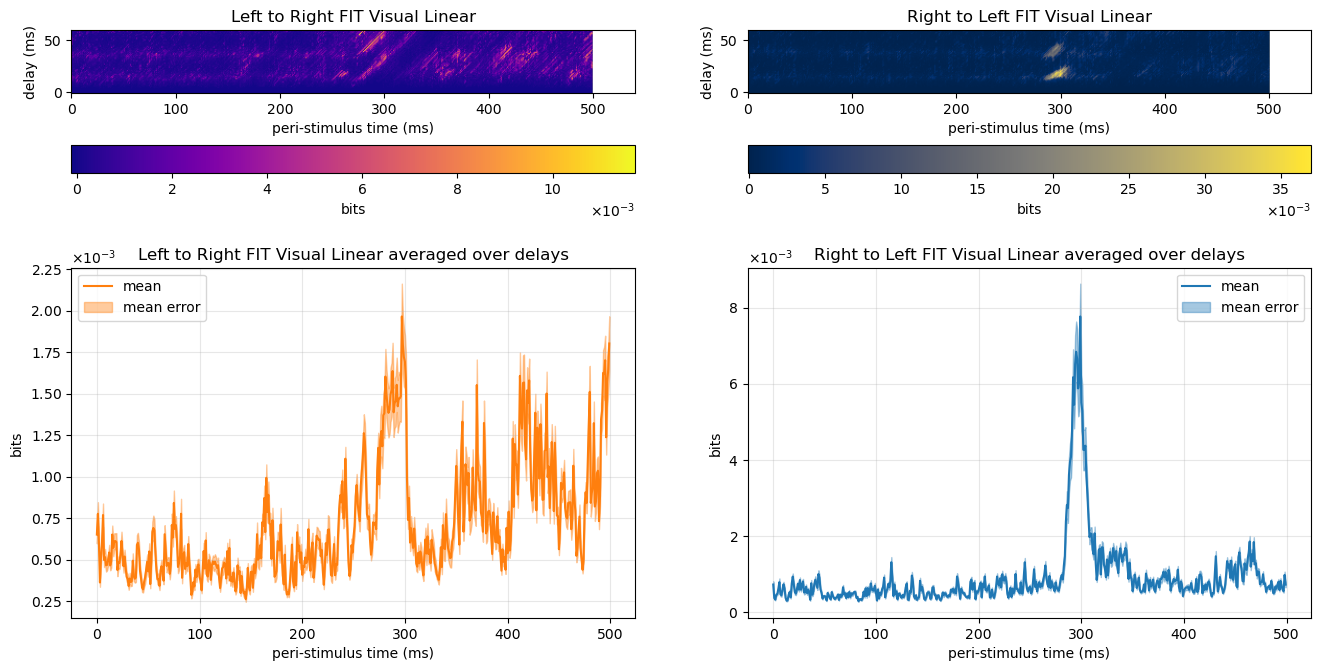

In [81]:
plot_map4(lrl_fit_vis.T[:,0:530], rll_fit_vis.T[:,0:530], 'FIT Visual Linear')

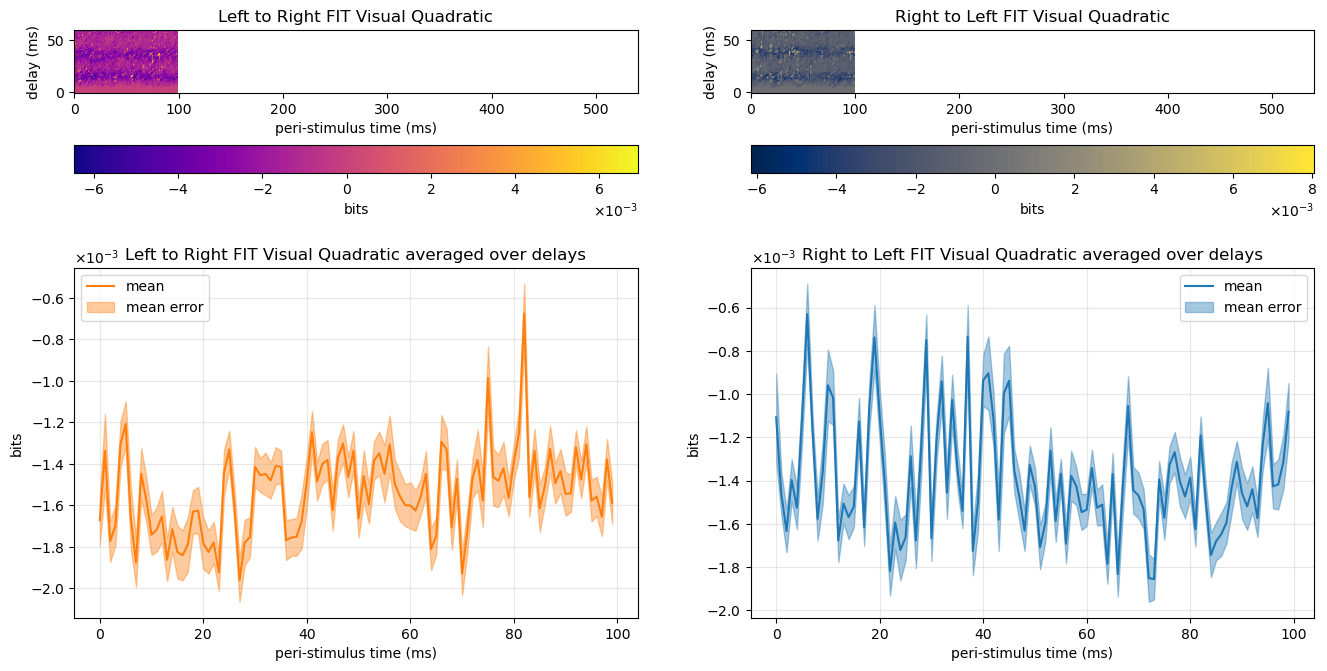

In [45]:
plot_map4(lrq_fit_vis.T[:,0:530], rlq_fit_vis.T[:,0:530], 'FIT Visual Quadratic')

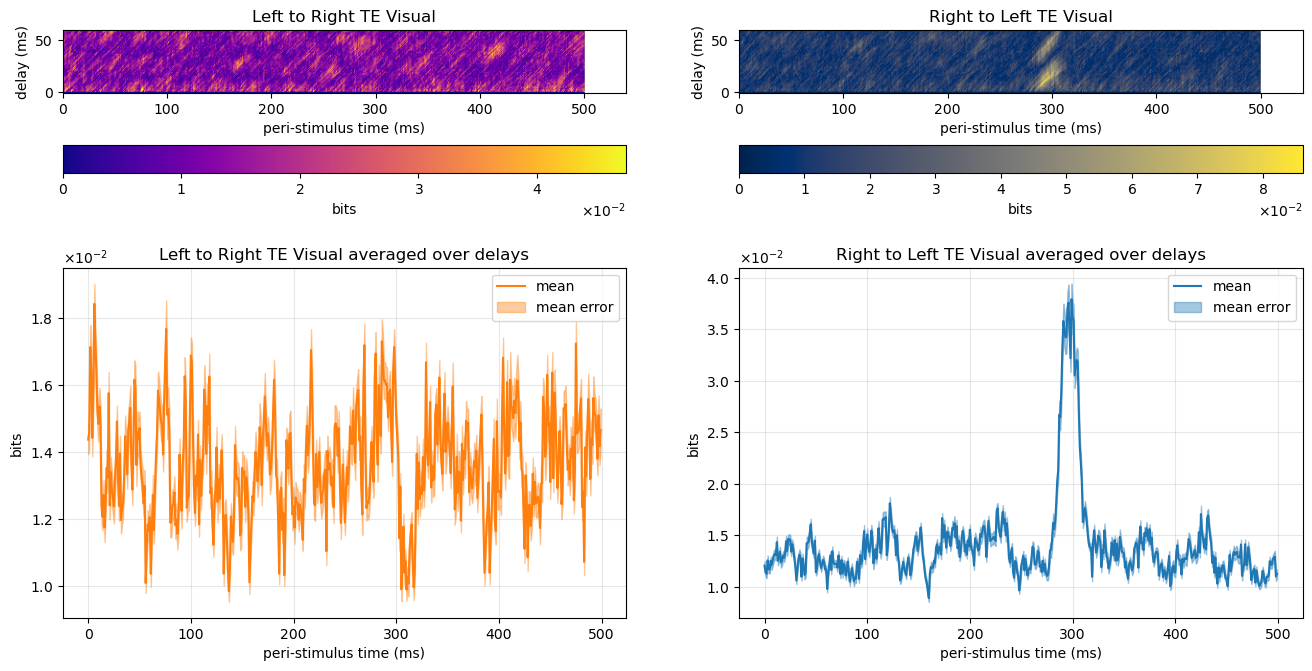

In [82]:
plot_map4(lr_di_vis.T[:,0:530], rl_di_vis.T[:,0:530], 'TE Visual')

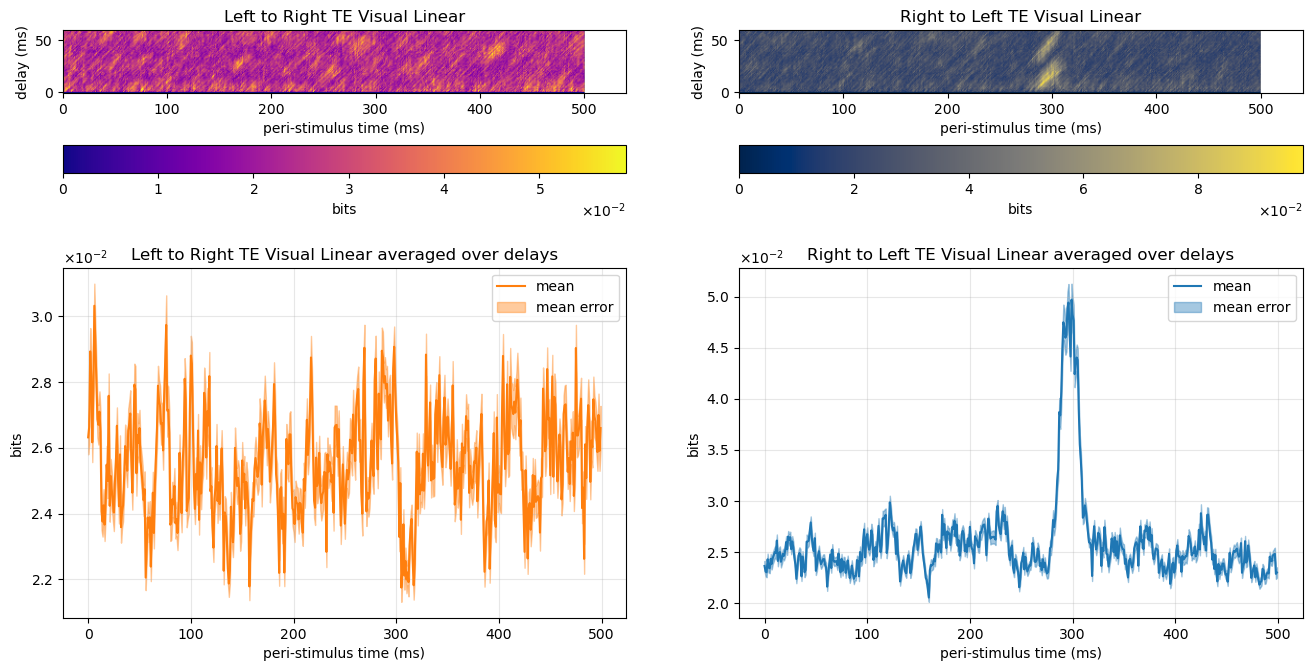

In [83]:
plot_map4(lrl_di_vis.T[:,0:530], rll_di_vis.T[:,0:530], 'TE Visual Linear')

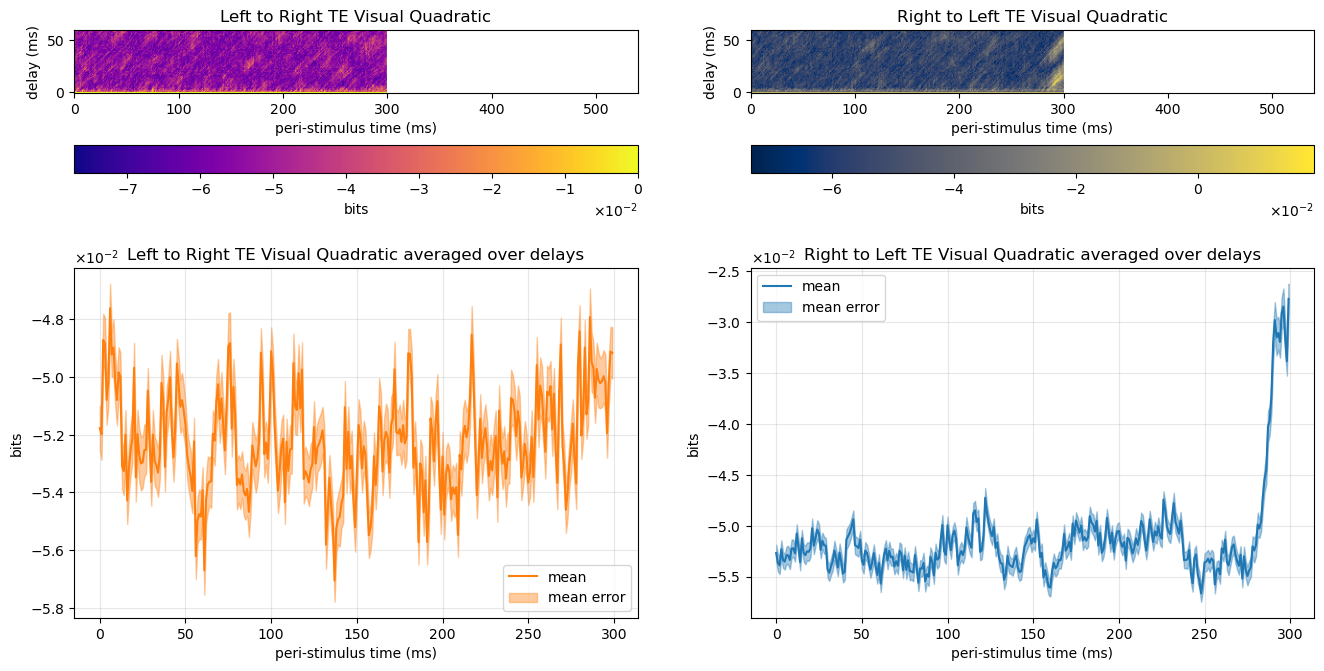

In [59]:
plot_map4(lrq_di_vis.T[:,0:530], rlq_di_vis.T[:,0:530], 'TE Visual Quadratic')

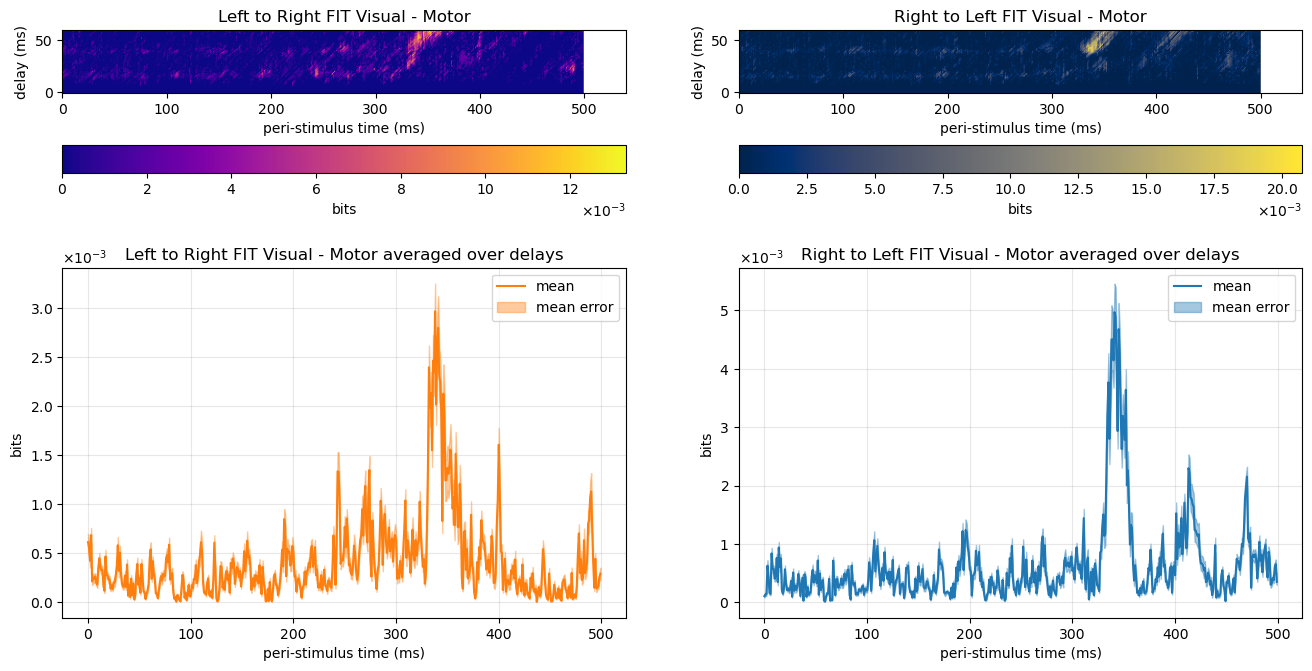

In [84]:
plot_map4(lr_fit_mot.T[:,0:530], rl_fit_mot.T[:,0:530], 'FIT Visual - Motor')

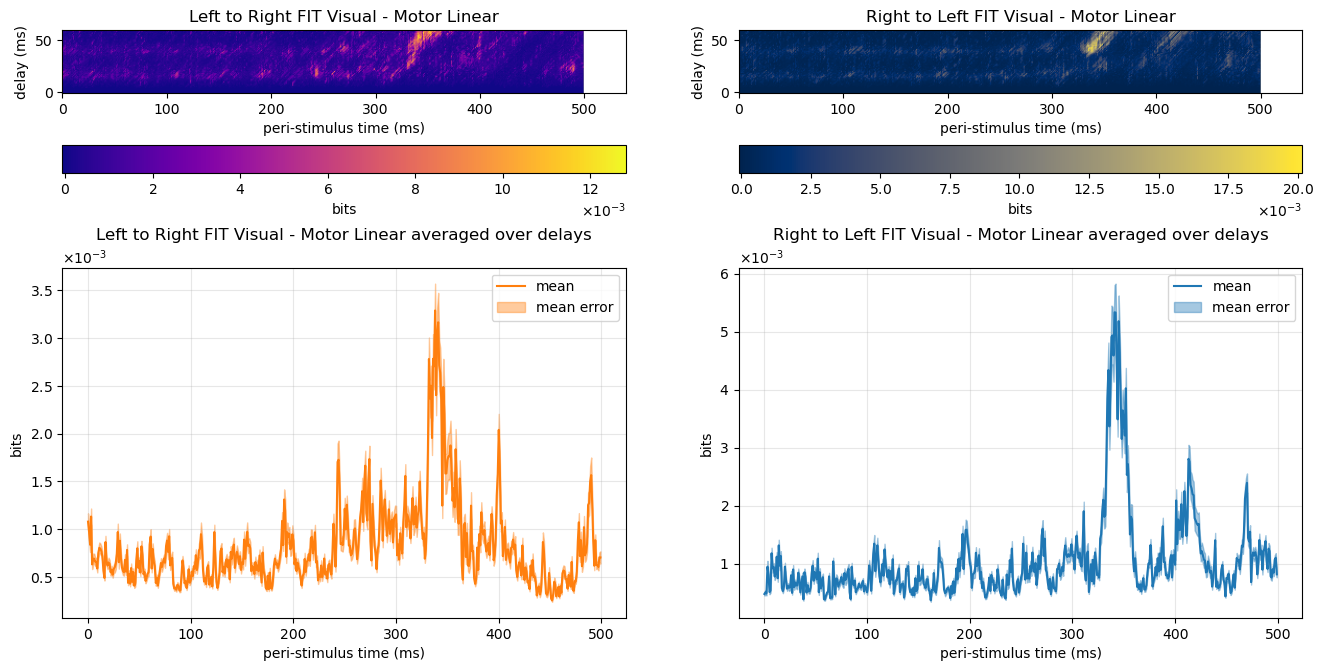

In [85]:
plot_map4(lrl_fit_mot.T[:,0:530], rll_fit_mot.T[:,0:530], 'FIT Visual - Motor Linear')

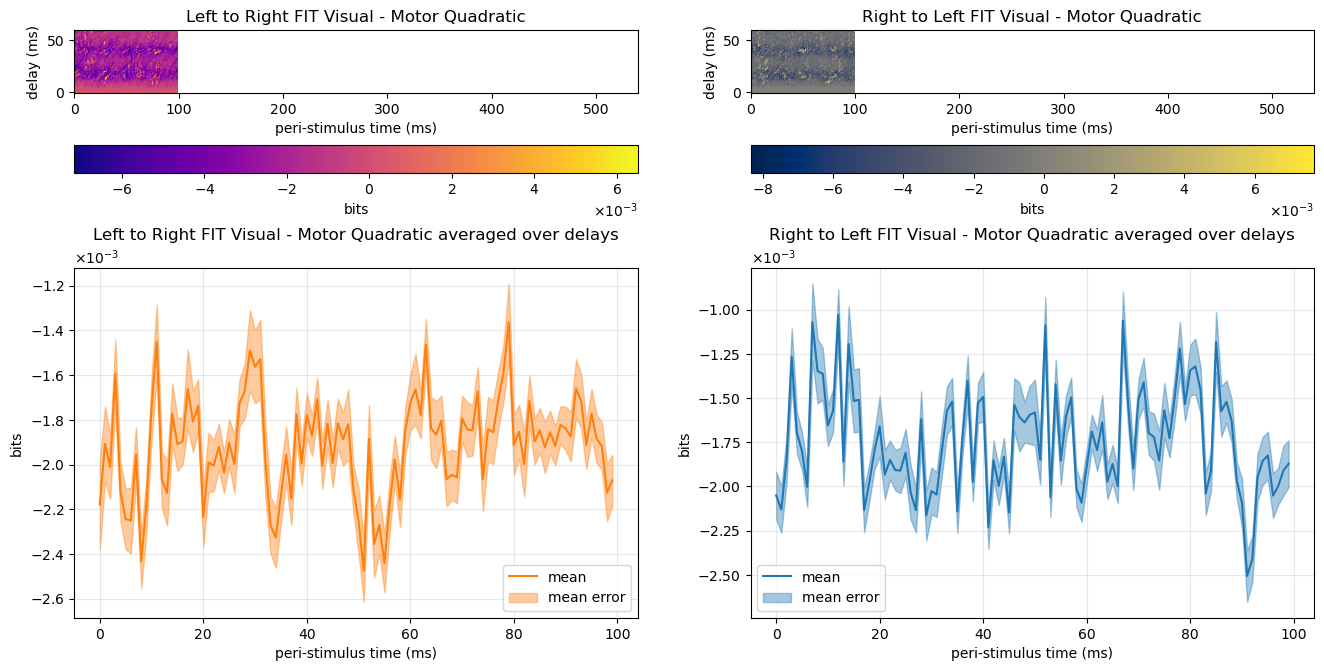

In [43]:
plot_map4(lrq_fit_mot.T[:,0:530], rlq_fit_mot.T[:,0:530], 'FIT Visual - Motor Quadratic')

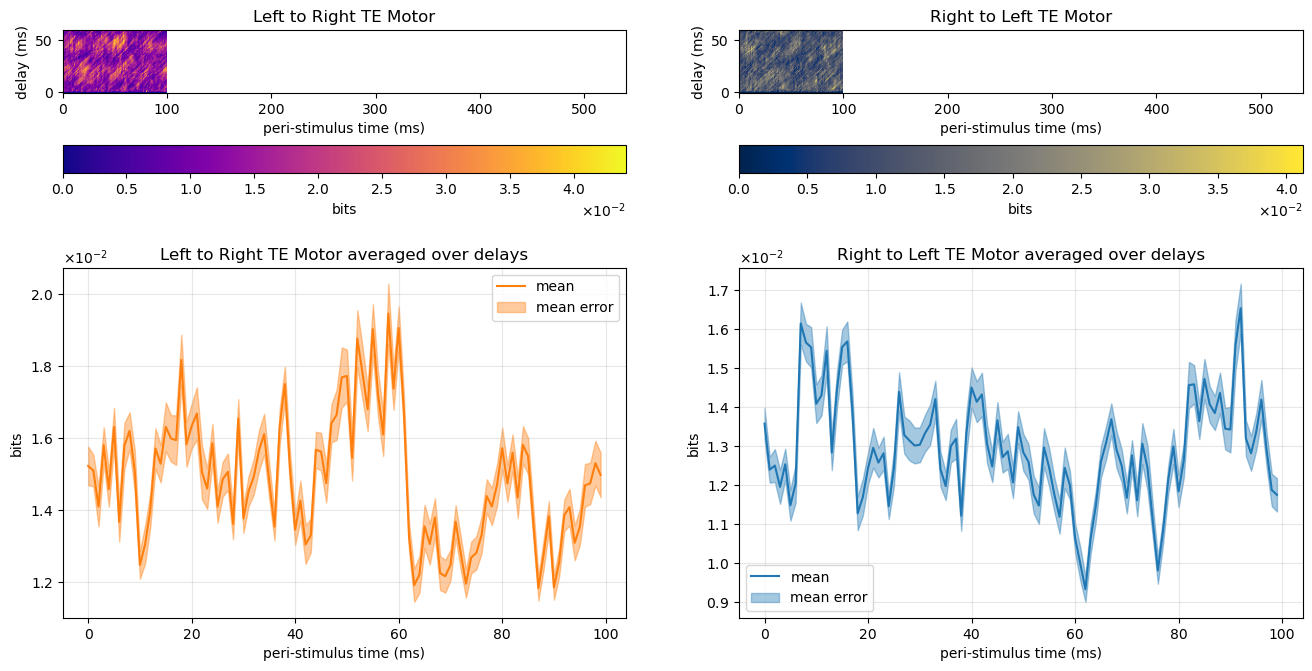

In [44]:
plot_map4(lr_di_mot.T[:,0:530], rl_di_mot.T[:,0:530], 'TE Motor')

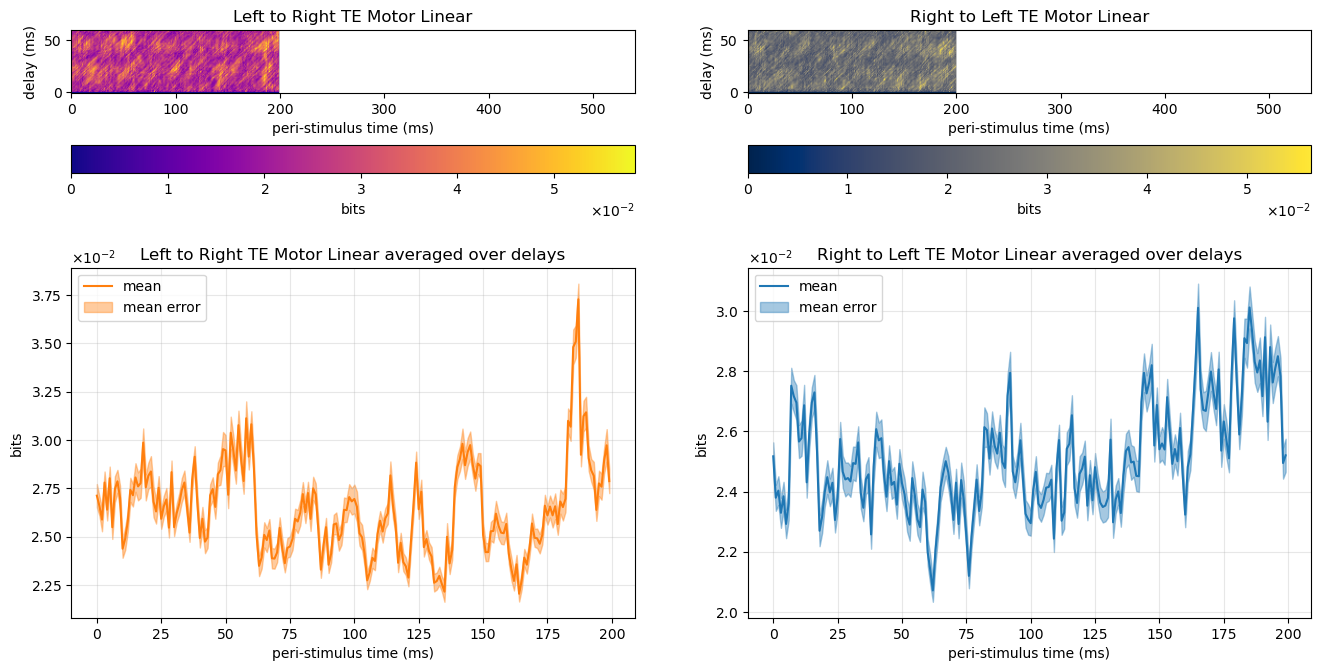

In [48]:
plot_map4(lrl_di_mot.T[:,0:530], rll_di_mot.T[:,0:530], 'TE Motor Linear')

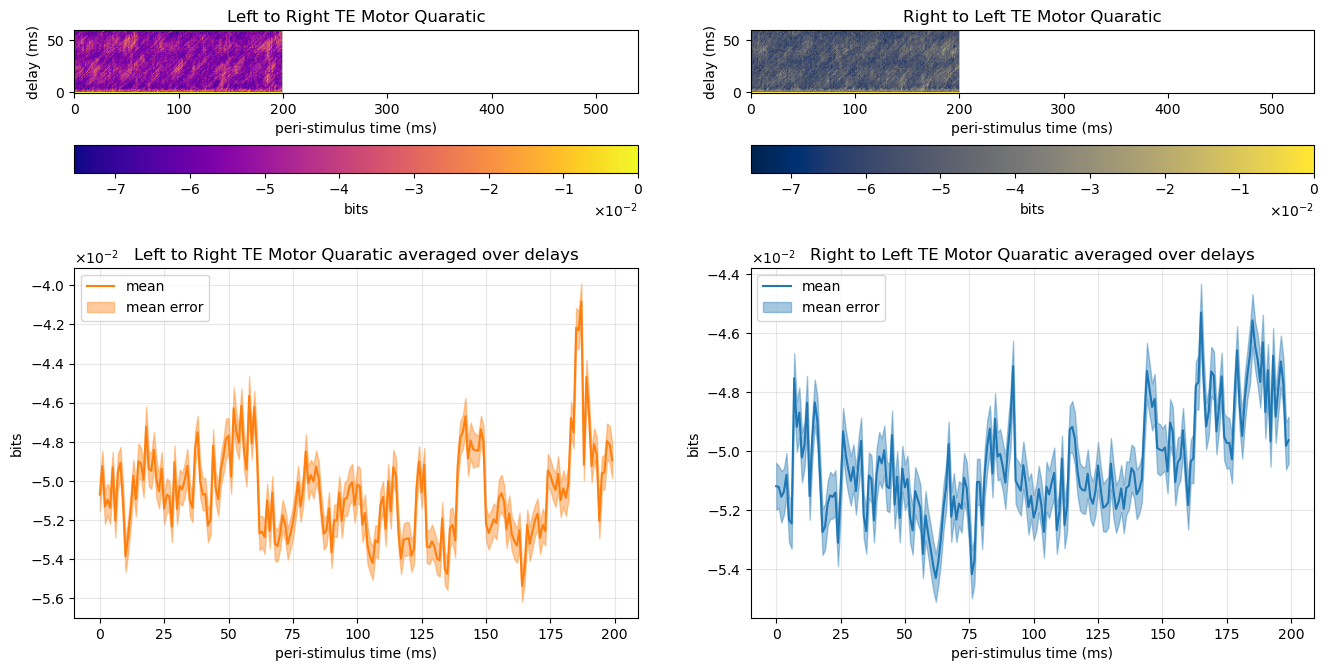

In [49]:
plot_map4(lrq_di_mot.T[:,0:530], rlq_di_mot.T[:,0:530], 'TE Motor Quaratic')